In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from WindowGenerator import WindowGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Functions

In [ ]:
MAX_EPOCHS = 25

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Data reading

In [ ]:
path = "./drive/MyDrive/ICT4building/"
figure_path = "./drive/MyDrive/ICT4building/prediction_figure/"
data_raw = pd.read_csv(path+"Data4prediction2.csv")[0:8760]

In [ ]:
data_raw.columns

Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
       'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
       'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
       'Environment:Site Wind Speed [m/s](Hourly)',
       'Environment:Site Wind Direction [deg](Hourly)',
       'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
       'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
       'Environment:Site Solar Azimuth Angle [deg](Hourly)',
       'Environment:Site Solar Altitude Angle [deg](Hourly)',
       'Mean Operative Temperature', 'Electricity:Facility [J](Hourly)',
       'DistrictCooling:Facility [J](Hourly)',
       'DistrictHeating:Facility [J](Hourly)', 'Total energy[J](Hourly)'],
      dtype='object')

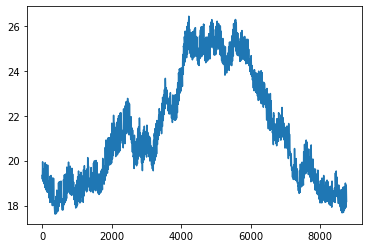

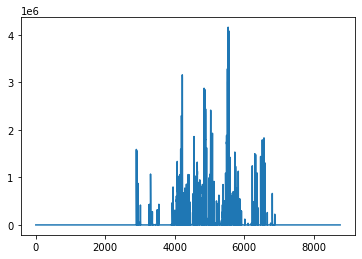

In [ ]:
plt.figure()
plt.plot(data_raw["Mean Operative Temperature"])
plt.figure()
plt.plot(data_raw["DistrictCooling:Facility [J](Hourly)"])

In [ ]:
df_winter=pd.concat([data_raw[len(data_raw)-744:-1], data_raw[0:1416]], ignore_index=True, sort=False)
df_spring=data_raw[1417:3625]
df_summer=data_raw[3636:5809]
df_autumn=data_raw[5809:len(data_raw)-745]

In [ ]:
print(len(df_winter),len(df_spring),len(df_summer),len(df_autumn))

2159 2208 2173 2206


# Data pre-processing

In [ ]:
save_fig = False
predict_steps = 12 # Future Hours
train_num=24*7
test_num=train_num
season = "autumn"
labels = ['Mean Operative Temperature']
# labels = ['Electricity:Facility [J](Hourly)']
# labels = ['DistrictCooling:Facility [J](Hourly)']
# labels = ['DistrictHeating:Facility [J](Hourly)']
if season == "winter":
  data_set=df_winter.copy()
elif season == "spring":
  data_set=df_spring.copy()
elif season == "summer":
  data_set=df_summer.copy()
elif season == "autumn":
  data_set=df_autumn.copy()
else:
  raise ValueError

features = ['Date/Time',\
            'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',\
            'Environment:Site Wind Speed [m/s](Hourly)',\
            'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',\
            'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',\
            'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',\
            'Environment:Site Solar Azimuth Angle [deg](Hourly)',\
            'Environment:Site Solar Altitude Angle [deg](Hourly)'
            ]
data_set=data_set[features+labels]

In [ ]:
data_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Date/Time,2206.0,1.129419e+09,2.293062e+06,1.125450e+09,1.127434e+09,1.129419e+09,1.131404e+09,1.133388e+09
Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),2206.0,1.237172e+01,5.626220e+00,-1.100000e+00,7.877083e+00,1.250417e+01,1.650833e+01,2.755833e+01
Environment:Site Wind Speed [m/s](Hourly),2206.0,1.322828e+00,1.270757e+00,0.000000e+00,4.000000e-01,9.250000e-01,1.843750e+00,8.508333e+00
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),2206.0,5.892227e+01,8.915029e+01,0.000000e+00,0.000000e+00,0.000000e+00,9.260417e+01,3.792500e+02
Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),2206.0,1.101794e+02,2.204936e+02,0.000000e+00,0.000000e+00,0.000000e+00,8.108333e+01,9.760000e+02
Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),2206.0,9.535561e+04,2.934051e+02,9.451033e+04,9.516667e+04,9.536312e+04,9.556979e+04,9.606292e+04
Environment:Site Solar Azimuth Angle [deg](Hourly),2206.0,1.763018e+02,9.691670e+01,4.611114e+00,9.364159e+01,1.753247e+02,2.616009e+02,3.431417e+02
Environment:Site Solar Altitude Angle [deg](Hourly),2206.0,-6.341910e+00,3.176233e+01,-6.623227e+01,-3.490267e+01,-5.643730e+00,2.222027e+01,5.389381e+01
Mean Operative Temperature,2206.0,2.130342e+01,1.899746e+00,1.811816e+01,1.955967e+01,2.116117e+01,2.294923e+01,2.553400e+01


In [ ]:
## convert datetime to sin
day = data_set['Date/Time']
data_set['Date/Time'] = np.sin(day*2*np.pi/(24*7))

In [ ]:
column_indices = {name: i for i, name in enumerate(data_set.columns)}

n = len(data_set)
train_df = data_set[0:int(n*0.7)]
val_df = data_set[int(n*0.7):int(n*0.9)]
test_df = data_set[int(n*0.9):]
num_features = data_set.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

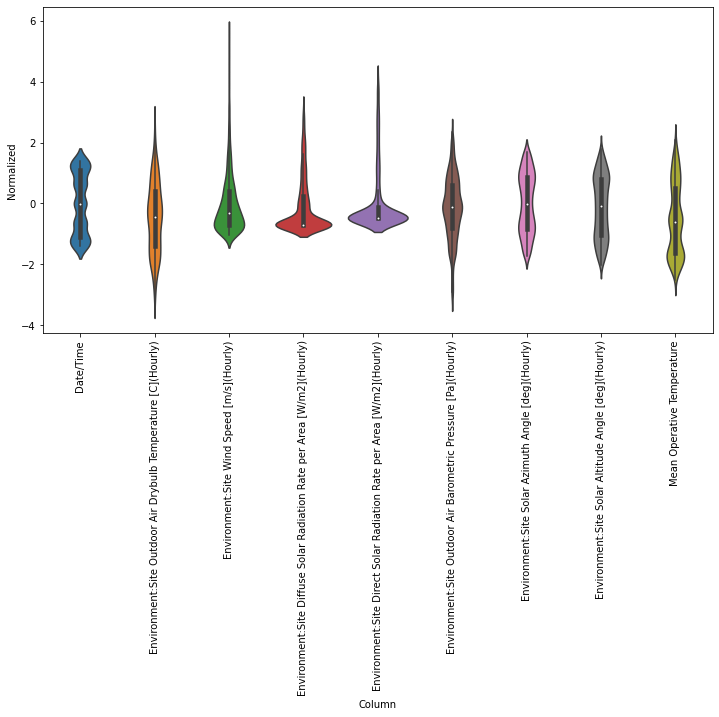

In [ ]:
df_std = (data_set - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_set.keys(), rotation=90)

In [ ]:
wide_window = WindowGenerator(
                    input_width=train_num, label_width=test_num, shift=predict_steps,\
                    train_df=train_df,val_df=val_df,test_df=test_df,\
                    label_columns=labels)

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(predict_steps,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -predict_steps:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(predict_steps)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(train_num*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([train_num, num_features])
])

In [ ]:
if predict_steps == 1:
  model = conv_model
elif predict_steps > 1:
  model =multi_conv_model
else:
  raise ValueError

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model(wide_window.example[0]).shape)

Input shape: (32, 168, 9)
Output shape: (32, 168, 9)


In [ ]:
print(wide_window.input_indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]


In [ ]:
history = compile_and_fit(model, wide_window)
IPython.display.clear_output()

In [ ]:
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['LSTM'] = model.evaluate(wide_window.val)
performance['LSTM'] = model.evaluate(wide_window.test, verbose=0)

9/9 [==============================] - 0s 5ms/step - loss: 0.1392 - mean_absolute_error: 0.2637


In [ ]:
print(model.metrics_names.index('mean_absolute_error'))
print(val_performance['LSTM'])

1
[0.13915595412254333, 0.2636948227882385]


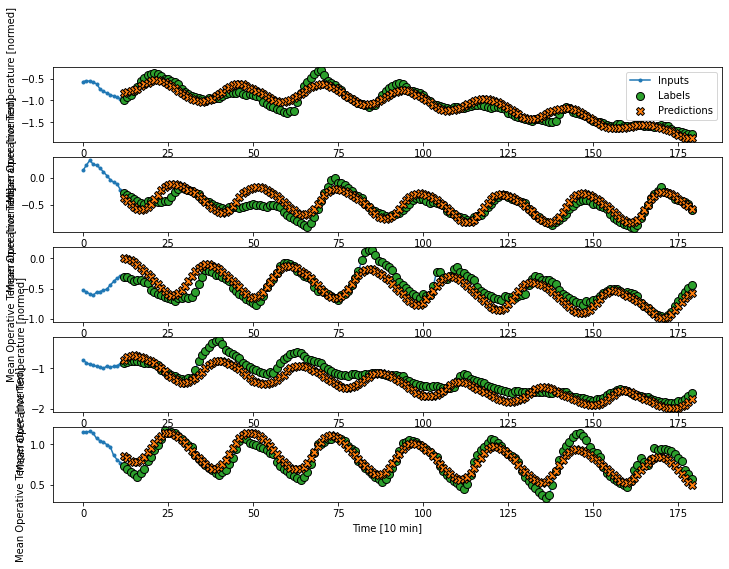

In [ ]:
wide_window.plot(model = model,plot_col=labels[0],max_subplots=5)

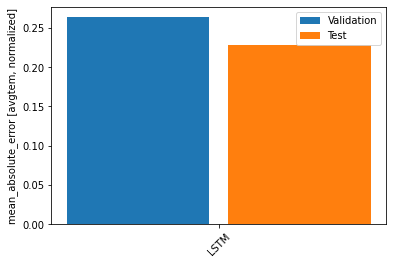

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [avgtem, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
print(performance)

{'LSTM': [0.07969454675912857, 0.22769835591316223]}


In [ ]:
inputs_tmp, labels_tmp = wide_window.example_test

In [ ]:
predictions = model(inputs_tmp)

In [ ]:
obversion = labels_tmp[3,:,0]*train_std[labels[0]]+train_mean[labels[0]]
test_result = predictions[3,:,0]*train_std[labels[0]]+train_mean[labels[0]]

if labels[0]!="Mean Operative Temperature":
  obversion=obversion/3.6e6
  test_result=test_result/3.61e6

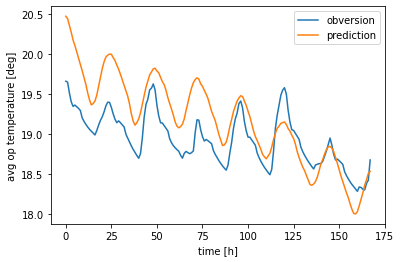

In [ ]:
plt.figure()
plt.plot(obversion,label="obversion")
plt.plot(test_result,label="prediction")
plt.xlabel("time [h]")
plt.ylabel("avg op temperature [deg]")
plt.legend()
if labels[0]=="Mean Operative Temperature" and save_fig==True:
  plt.savefig(figure_path+'CNN_temperature_'+season+'.png')

In [ ]:
avg_mse = 0
for i in range(len(labels_tmp)):
  obversion = labels_tmp[i,:,0]*train_std[labels[0]]+train_mean[labels[0]]
  test_result = predictions[i,:,0]*train_std[labels[0]]+train_mean[labels[0]]

  if labels[0]!="Mean Operative Temperature":
    obversion=obversion/3.6e6
    test_result=test_result/3.61e6
  avg_mse += (mse(obversion,test_result))

print(avg_mse/len(labels_tmp))

0.20398797746747732
